In [1]:
print("hi")

hi


In [ ]:
ds_path = r"/kaggle/input/diabetic-retinopathy-resized/resized_train_cropped"
images_path = r"/kaggle/input/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped"
csv_path = r"/kaggle/input/diabetic-retinopathy-resized/trainLabels_cropped.csv"

In [2]:
import pandas as pd
import os # Might be useful later, let's import it

# Define the path to the CSV file (using the variable you provided)
csv_path = r"/kaggle/input/diabetic-retinopathy-resized/trainLabels_cropped.csv"

# Check if the file exists (good practice)
if not os.path.exists(csv_path):
    print(f"Error: CSV file not found at {csv_path}")
else:
    # Load the CSV into a pandas DataFrame
    train_labels_df = pd.read_csv(csv_path)

    # Display the first few rows to see the structure
    print("First 5 rows of the trainLabels_cropped.csv:")
    print(train_labels_df.head())

    # Display the number of rows and columns
    print("\nShape of the DataFrame:")
    print(train_labels_df.shape)

    # Check the distribution of the 'level' column (the target variable)
    print("\nDistribution of DR Stages ('level'):")
    print(train_labels_df['level'].value_counts())

    # Display the distribution as percentages
    print("\nDistribution of DR Stages ('level') as percentages:")
    print(train_labels_df['level'].value_counts(normalize=True) * 100)

First 5 rows of the trainLabels_cropped.csv:
   Unnamed: 0.1  Unnamed: 0     image  level
0             0           0   10_left      0
1             1           1  10_right      0
2             2           2   13_left      0
3             3           3  13_right      0
4             4           4   15_left      1

Shape of the DataFrame:
(35108, 4)

Distribution of DR Stages ('level'):
level
0    25802
2     5288
1     2438
3      872
4      708
Name: count, dtype: int64

Distribution of DR Stages ('level') as percentages:
level
0    73.493221
2    15.062094
1     6.944286
3     2.483764
4     2.016634
Name: proportion, dtype: float64



Verifying existence of 10 sample image files:
All 10 sample image files were found.

Displaying sample images for each DR stage:


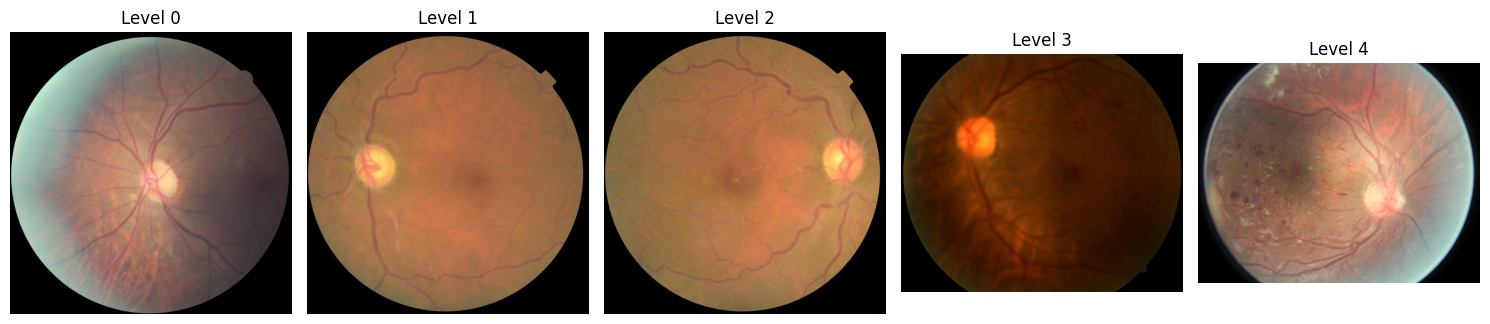

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image # Using Pillow for image loading
import numpy as np

# Define the paths (using the variables you provided)
ds_path = r"/kaggle/input/diabetic-retinopathy-resized/resized_train_cropped" # Parent directory
images_path = r"/kaggle/input/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped" # Directory containing images
csv_path = r"/kaggle/input/diabetic-retinopathy-resized/trainLabels_cropped.csv"

# Load the labels again just in case
train_labels_df = pd.read_csv(csv_path)

# --- 1. Verify Image Files ---
# Let's check if a few sample image files exist
sample_image_names = train_labels_df['image'].sample(10).tolist() # Get 10 random image names

print("\nVerifying existence of 10 sample image files:")
all_exist = True
for img_name in sample_image_names:
    img_file_path = os.path.join(images_path, f"{img_name}.jpeg") # Assuming images are .jpeg based on common datasets
    if os.path.exists(img_file_path):
        # print(f"Found: {img_file_path}") # Uncomment to see each one being found
        pass
    else:
        print(f"Error: Image file not found: {img_file_path}")
        all_exist = False

if all_exist:
    print("All 10 sample image files were found.")
else:
    print("Some sample image files were NOT found. Please check the image path and file extension.")

# --- 2. Visualize Sample Images per Class ---

print("\nDisplaying sample images for each DR stage:")

# Get one image file name for each level (0 to 4)
sample_images_per_level = {}
for level in sorted(train_labels_df['level'].unique()):
    # Find the first image name for this level
    img_name = train_labels_df[train_labels_df['level'] == level].iloc[0]['image']
    sample_images_per_level[level] = img_name

# Plotting
plt.figure(figsize=(15, 5)) # Adjust figure size as needed

for i, (level, img_name) in enumerate(sample_images_per_level.items()):
    img_file_path = os.path.join(images_path, f"{img_name}.jpeg") # Assuming .jpeg
    try:
        img = Image.open(img_file_path)
        plt.subplot(1, len(sample_images_per_level), i + 1)
        plt.imshow(img)
        plt.title(f"Level {level}")
        plt.axis('off') # Hide axes

    except FileNotFoundError:
        print(f"Could not load image for Level {level} at {img_file_path}")
    except Exception as e:
        print(f"An error occurred loading image for Level {level}: {e}")


plt.tight_layout() # Adjust layout to prevent titles overlapping
plt.show()


Displaying 10 sample images after custom preprocessing:
Processing: 10_left.jpeg
Loaded image shape: (1024, 1024, 3), dtype: uint8, min: 0, max: 255
After BGR to RGB: shape: (1024, 1024, 3), min: 0, max: 255
After crop_black: shape: (1005, 1010, 3), min: 0, max: 255
After resize (256x256): shape: (256, 256, 3), min: 0, max: 255
After addWeighted (enhancement): shape: (256, 256, 3), min: 0, max: 255
After circle_crop: shape: (256, 256, 3), min: 0, max: 255
Processing: 10_right.jpeg
Loaded image shape: (1024, 1024, 3), dtype: uint8, min: 0, max: 142
After BGR to RGB: shape: (1024, 1024, 3), min: 0, max: 142
After crop_black: shape: (1005, 1010, 3), min: 0, max: 142
After resize (256x256): shape: (256, 256, 3), min: 0, max: 137
After addWeighted (enhancement): shape: (256, 256, 3), min: 0, max: 255
After circle_crop: shape: (256, 256, 3), min: 0, max: 255
Processing: 13_left.jpeg
Loaded image shape: (954, 1024, 3), dtype: uint8, min: 0, max: 255
After BGR to RGB: shape: (954, 1024, 3), m

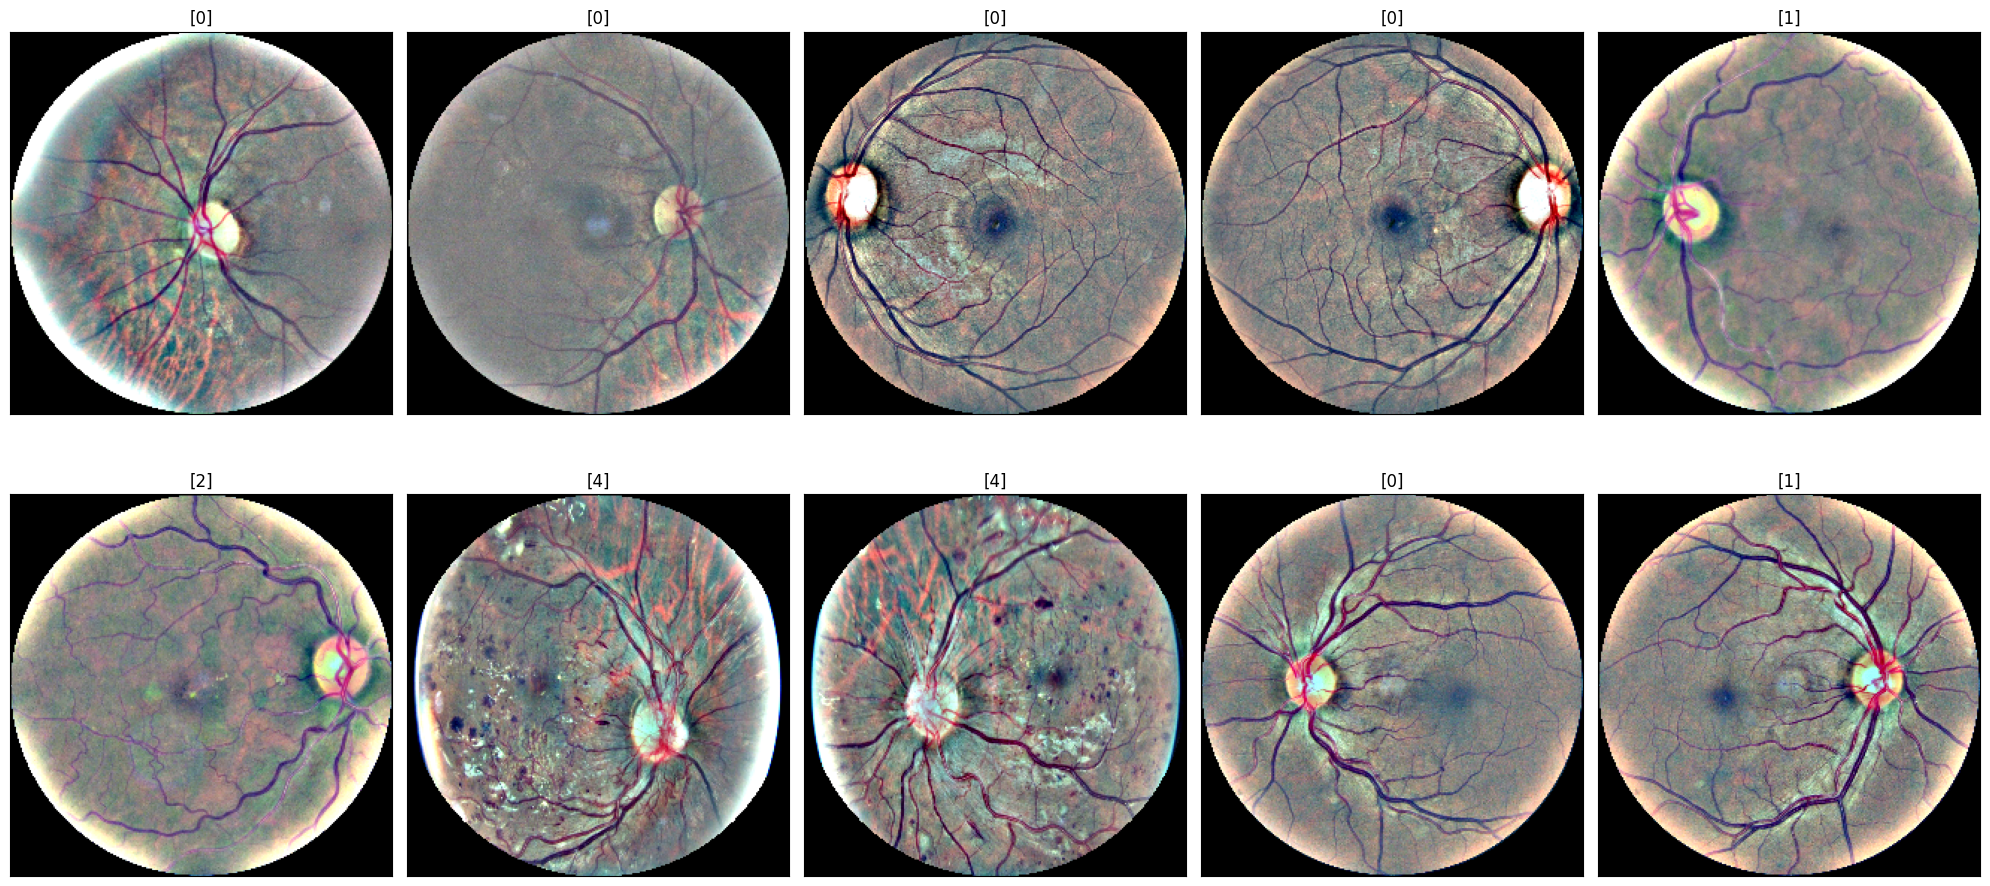

In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import random # For random_crop

# Define paths (using the variables you provided)
images_path = r"/kaggle/input/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped" # Directory containing images
csv_path = r"/kaggle/input/diabetic-retinopathy-resized/trainLabels_cropped.csv"

# Define target image size
IMAGE_SIZE = 256 # Based on the shared code example

# --- Implement the Helper Functions ---

def crop_black(img, tol=7):
    '''
    Perform automatic crop of black areas
    '''
    if img is None: # Add check
        return None
    if img.ndim == 2:
        mask = img > tol
        # Add check for empty result
        if mask.any():
             return img[np.ix_(mask.any(1),mask.any(0))]
        else:
             return img # Return original if mask is empty
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]

        if (check_shape == 0):
            return img # Return original if mask is empty or all black
        else:
            img1 = img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2 = img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3 = img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img  = np.stack([img1, img2, img3], axis = -1)
            return img
    return img # Return original if dimensions are unexpected


def circle_crop(img, sigmaX=10): # sigmaX param is unused here, kept for signature match
    '''
    Perform circular crop around image center
    '''
    if img is None: # Add check
        return None

    height, width, depth = img.shape

    # Resize to make it square first (if not already square)
    # Only resize if dimensions are different
    if height != width:
        largest_side = np.max((height, width))
        img = cv2.resize(img, (largest_side, largest_side))
        height, width, depth = img.shape # Update dimensions after resize

    x = int(width / 2)
    y = int(height / 2)
    r = np.amin((x,y))

    circle_img = np.zeros((height, width), np.uint8)
    # Draw a filled white circle on a black background mask
    cv2.circle(circle_img, (x,y), int(r), (1), thickness = -1) # Use (1) for uint8 white

    # Apply the mask to the image
    # Use the mask argument directly
    img = cv2.bitwise_and(img, img, mask = circle_img)

    return img

# The random_crop from the original notebook
def random_crop(img, size=(0.9, 1)):
    '''
    Random crop (Data Augmentation)
    '''
    if img is None: # Add check
        return None

    height, width, depth = img.shape

    # Ensure image is large enough to crop
    if height < int((1-size[0]) * height) + 1 or width < int((1-size[0]) * width) + 1:
         # Cannot crop, return original or resized original if smaller than target
         return img


    cut = 1 - random.uniform(size[0], size[1])

    # Calculate crop dimensions
    target_h = int((1 - cut) * height)
    target_w = int((1 - cut) * width)

    # Ensure target dimensions are positive
    if target_h <= 0 or target_w <= 0:
        return img # Cannot crop meaningfully

    i = random.randint(0, height - target_h)
    j = random.randint(0, width - target_w)
    h = i + target_h
    w = j + target_w

    img = img[i:h, j:w, :]
    return img

# --- Implement the Core Preprocessing Function ---
def preprocess_image_custom(image_path, sigmaX=10, do_random_crop=False, image_size=IMAGE_SIZE):
    '''
    Loads image and applies custom preprocessing including Ben Graham style enhancement
    '''
    # --- Debug Print 1: Loading ---
    print(f"Processing: {os.path.basename(image_path)}")

    # Import image using OpenCV - Try color first
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)

    # --- Debug Print 2: After Initial Load ---
    if image is None:
        print(f"Error: cv2.imread failed to load {image_path}. Image is None.")
        return None
    else:
        print(f"Loaded image shape: {image.shape}, dtype: {image.dtype}, min: {image.min()}, max: {image.max()}")
        # Convert to RGB (OpenCV loads as BGR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        print(f"After BGR to RGB: shape: {image.shape}, min: {image.min()}, max: {image.max()}")


    # Apply automatic black crop
    image = crop_black(image, tol=7)
    # --- Debug Print 3: After crop_black ---
    if image is None:
        print("Error: crop_black returned None.")
        return None
    print(f"After crop_black: shape: {image.shape}, min: {image.min()}, max: {image.max()}")


    # Optional Random Crop (Data Augmentation) - Apply *before* resize as in original code
    if do_random_crop:
         # Check if image is large enough for random crop before attempting
         if image.shape[0] > image_size * 1.0 and image.shape[1] > image_size * 1.0 : # Heuristic check if potentially larger than target
             image = random_crop(image, size = (0.9, 1))
             # --- Debug Print 4a: After random_crop ---
             if image is None:
                 print("Error: random_crop returned None.")
                 return None
             print(f"After random_crop (if applied): shape: {image.shape}, min: {image.min()}, max: {image.max()}")


    # Resize to target size
    image = cv2.resize(image, (image_size, image_size))
    # --- Debug Print 4b/5: After resize ---
    print(f"After resize ({image_size}x{image_size}): shape: {image.shape}, min: {image.min()}, max: {image.max()}")


    # Apply the Ben Graham style enhancement
    # Use dtype float32 for intermediate calculations to avoid overflow/clipping
    image = image.astype(np.float32) # Convert to float before addWeighted
    image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0, 0), sigmaX), -4, 128)
    # Ensure results are clipped to the valid range [0, 255] and convert back to uint8
    image = np.clip(image, 0, 255).astype(np.uint8) # Clip and convert back
    # --- Debug Print 6: After addWeighted enhancement ---
    print(f"After addWeighted (enhancement): shape: {image.shape}, min: {image.min()}, max: {image.max()}")


    # Apply circular crop
    image = circle_crop(image, sigmaX=sigmaX) # sigmaX is ignored in circle_crop func.
    # --- Debug Print 7: After circle_crop ---
    if image is None:
        print("Error: circle_crop returned None.")
        return None
    print(f"After circle_crop: shape: {image.shape}, min: {image.min()}, max: {image.max()}")


    # Output is a NumPy array (HxWxChannels) in uint8.
    return image


# --- Custom PyTorch Dataset ---

class DRDataset(Dataset):

    def __init__(self, csv_file, image_dir, transform=None, do_random_crop=False, image_size=IMAGE_SIZE, file_extension=".jpeg"):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            image_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
            do_random_crop (bool): Whether to apply random cropping (data augmentation).
            image_size (int): Desired output image size.
            file_extension (string): Initial assumed extension (will also try .png).
        """
        self.labels_df = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform
        self.do_random_crop = do_random_crop
        self.image_size = image_size
        self.initial_extension = file_extension # Store initial guess
        self.sigmaX = 10 # Using the default from the original prepare_image

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name_base = self.labels_df.loc[idx, 'image']
        label = self.labels_df.loc[idx, 'level']

        # Try initial extension first
        img_file_path = os.path.join(self.image_dir, img_name_base + self.initial_extension)

        # Check if the file exists with the initial extension
        if not os.path.exists(img_file_path):
            # If not found, try the other common extension (.png if initial was .jpeg, or .jpeg if initial was .png)
            if self.initial_extension == ".jpeg":
                 alt_extension = ".png"
            else:
                 alt_extension = ".jpeg" # Assuming only these two common extensions

            img_file_path = os.path.join(self.image_dir, img_name_base + alt_extension)
            print(f"Warning: {self.initial_extension} not found, trying {alt_extension} for {img_name_base}")

            # Check again
            if not os.path.exists(img_file_path):
                print(f"Error: Image file not found with either {self.initial_extension} or {alt_extension}: {img_name_base}")
                # Handle missing image - return dummy data or skip sample
                # For this example, let's return a black image tensor and -1 label to indicate error
                dummy_img = torch.zeros(3, self.image_size, self.image_size, dtype=torch.float32)
                dummy_label = -1 # Indicate missing data
                return dummy_img, dummy_label


        # Apply the custom preprocessing using OpenCV
        image = preprocess_image_custom(img_file_path,
                                        sigmaX=self.sigmaX,
                                        do_random_crop=self.do_random_crop,
                                        image_size=self.image_size)

        # Check if preprocessing returned None (meaning an error occurred inside)
        if image is None:
             print(f"Error during preprocessing for {img_file_path}. Returning dummy data.")
             dummy_img = torch.zeros(3, self.image_size, self.image_size, dtype=torch.float32)
             dummy_label = -1 # Indicate missing data
             return dummy_img, dummy_label


        # Apply standard PyTorch transforms (ToTensor, Normalization, etc.)
        if self.transform:
            image = self.transform(image) # Assuming transform includes ToTensor and Normalize
        else:
            # If no transforms are specified, just convert the HWC uint8 NumPy array to CHW float tensor [0.0, 1.0]
             image = transforms.ToTensor()(image)

        return image, label


# --- Example Usage and Visualization ---

# Define transforms for the training data (includes data augmentation via do_random_crop=True in Dataset)
# We need normalization stats eventually, but not for visualizing the raw output of our custom processing.
# Let's just use ToTensor() for now.

# Transforms for training (includes data augmentation via do_random_crop=True in Dataset)
train_transforms = transforms.Compose([
    # ToTensor() converts the HxWxChannels uint8 NumPy array [0, 255] to a
    # PyTorch tensor CxHxW [0.0, 1.0].
    transforms.ToTensor(),
    # Normalization will go here later: transforms.Normalize(mean, std)
])

# Create an instance of the dataset
# Let's get a small sample to visualize the preprocessing result
# Set the initial_extension based on your guess or observation
# From the original Kaggle dataset page, .jpeg seems common for the resized images.
# Let's try .jpeg first, and the Dataset will try .png if .jpeg is not found.
sample_dataset = DRDataset(csv_file=csv_path,
                           image_dir=images_path,
                           transform=train_transforms, # Apply ToTensor here
                           do_random_crop=False, # Turn off random crop for consistent visualization
                           image_size=IMAGE_SIZE,
                           file_extension=".jpeg") # <- Start with .jpeg, will try .png if not found


# Create a DataLoader for the sample
# Use a small batch size and 0 workers for debugging
sample_loader = DataLoader(sample_dataset, batch_size=10, shuffle=False, num_workers=0)

# Display the processed images
print("\nDisplaying 10 sample images after custom preprocessing:")
for batch_i, (inputs, labels) in enumerate(sample_loader):

    # --- Debug Print 8: Tensor Values ---
    print(f"DataLoader batch {batch_i}: inputs shape: {inputs.shape}, dtype: {inputs.dtype}")
    # Check min/max of the tensor data before displaying
    if inputs.numel() > 0: # Check if tensor is not empty
        print(f"Inputs tensor min: {inputs.min().item()}, max: {inputs.max().item()}")
    else:
        print("Inputs tensor is empty.")


    # inputs are now PyTorch tensors (Batch x Channels x Height x Width)
    # labels are PyTorch tensors (Batch)

    fig = plt.figure(figsize=(20, 10))
    for i in range(inputs.size(0)): # Iterate through images in the batch
        ax = fig.add_subplot(2, 5, i + 1, xticks=[], yticks=[])
        # PyTorch tensors are CHW, matplotlib expects HWC for imshow
        # ToTensor scales to [0.0, 1.0], imshow expects this range or uint8 [0, 255]
        img_to_show = inputs[i].permute(1, 2, 0).numpy()
        # If the image came back as a black dummy (due to loading/processing error)
        # the label will be -1. We should handle that for display.
        label_text = f"[{labels[i].item()}]" if labels[i].item() != -1 else "Load/Proc Error"

        # Check if the image data is mostly zero (which would cause a black image)
        if np.mean(img_to_show) < 0.01: # Arbitrary threshold for 'mostly black'
             print(f"Warning: Image {i} in batch {batch_i} is likely black (mean pixel value < 0.01).")

        plt.imshow(img_to_show)
        ax.set_title(label_text)
    plt.tight_layout()
    plt.show()

    break # Only display the first batch

In [ ]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split

# Assume train_labels_df is already loaded from the previous step
# If not, load it again:
csv_path = r"/kaggle/input/diabetic-retinopathy-resized/trainLabels_cropped.csv"
if 'train_labels_df' not in locals() or train_labels_df.empty:
    if os.path.exists(csv_path):
        train_labels_df = pd.read_csv(csv_path)
        print("Loaded trainLabels_cropped.csv for splitting.")
    else:
        print(f"Error: CSV file not found at {csv_path}")
        # Exit or handle error appropriately if the dataframe couldn't be loaded

# Perform the first split: 80% Train, 20% Temp (Val+Test)
# Use stratify=train_labels_df['level'] to maintain class distribution
train_df, temp_df = train_test_split(
    train_labels_df,
    test_size=0.2,
    random_state=42, # Use a fixed random state for reproducibility
    stratify=train_labels_df['level']
)

# Perform the second split: Split Temp (20%) into 50% Val and 50% Test (resulting in 10% Val, 10% Test of original)
# Use stratify=temp_df['level'] to maintain class distribution within the temp set
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5, # 0.5 of 20% is 10%
    random_state=42, # Keep the same random state
    stratify=temp_df['level']
)

# --- Verify the Splits ---
print("\n--- Dataset Splits ---")
print(f"Total samples: {len(train_labels_df)}")
print(f"Train samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

print("\n--- Class Distribution in Train Set ---")
print(train_df['level'].value_counts().sort_index())
print(train_df['level'].value_counts(normalize=True).sort_index() * 100)

print("\n--- Class Distribution in Validation Set ---")
print(val_df['level'].value_counts().sort_index())
print(val_df['level'].value_counts(normalize=True).sort_index() * 100)

print("\n--- Class Distribution in Test Set ---")
print(test_df['level'].value_counts().sort_index())
print(test_df['level'].value_counts(normalize=True).sort_index() * 100)

# --- Important: Reset index of the dataframes for easy access in Dataset ---
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
print("\nIndexes reset for train_df, val_df, test_df.")

# (Keep the crop_black, circle_crop, random_crop, preprocess_image_custom functions as they are)

# --- Updated Custom PyTorch Dataset ---

class DRDataset(Dataset):

    # Modified __init__ to accept a dataframe directly
    def __init__(self, dataframe, image_dir, transform=None, do_random_crop=False, image_size=IMAGE_SIZE, file_extension=".jpeg"):
        """
        Args:
            dataframe (pd.DataFrame): DataFrame containing 'image' filenames and 'level' labels for this split.
            image_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
            do_random_crop (bool): Whether to apply random cropping (data augmentation).
            image_size (int): Desired output image size.
            file_extension (string): Initial assumed extension (will also try .png).
        """
        # Use the provided dataframe directly. Assumes index has been reset outside.
        self.labels_df = dataframe
        self.image_dir = image_dir
        self.transform = transform
        self.do_random_crop = do_random_crop
        self.image_size = image_size
        self.initial_extension = file_extension
        self.sigmaX = 10

        # Optional: Add a check to see if the dataframe has the expected columns
        if 'image' not in self.labels_df.columns or 'level' not in self.labels_df.columns:
            raise ValueError("DataFrame must contain 'image' and 'level' columns")

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        # The rest of the __getitem__ logic remains the same as the version that worked for visualization
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name_base = self.labels_df.loc[idx, 'image']
        label = self.labels_df.loc[idx, 'level']

        # Build image path, trying different extensions if necessary
        img_file_path = os.path.join(self.image_dir, img_name_base + self.initial_extension)
        if not os.path.exists(img_file_path):
            alt_extension = ".png" if self.initial_extension == ".jpeg" else ".jpeg"
            img_file_path = os.path.join(self.image_dir, img_name_base + alt_extension)
            if not os.path.exists(img_file_path):
                print(f"Error: Image file not found with either {self.initial_extension} or {alt_extension}: {img_name_base}")
                # Return dummy data if image is missing
                dummy_img = torch.zeros(3, self.image_size, self.image_size, dtype=torch.float32)
                dummy_label = -1 # Use -1 to indicate missing data/error
                return dummy_img, dummy_label


        # Apply the custom preprocessing
        image = preprocess_image_custom(img_file_path,
                                        sigmaX=self.sigmaX,
                                        do_random_crop=self.do_random_crop,
                                        image_size=self.image_size)

        # Check if preprocessing returned None (indicating an error inside)
        if image is None:
             print(f"Error during preprocessing for {img_file_path}. Returning dummy data.")
             dummy_img = torch.zeros(3, self.image_size, self.image_size, dtype=torch.float32)
             dummy_label = -1
             return dummy_img, dummy_label


        # Apply standard PyTorch transforms (ToTensor, Normalization, etc.)
        if self.transform:
            image = self.transform(image)
        else:
             # Default ToTensor if no transforms are provided
             image = transforms.ToTensor()(image)


        return image, label

# --- Example of how to instantiate DataLoaders for each split ---

# Define Transforms (Normalization will be added here later)
# For training, we will eventually add augmentations like RandomHorizontalFlip *after* ToTensor
# For now, just ToTensor is included.
train_transforms = transforms.Compose([transforms.ToTensor()]) # Add Normalize(mean, std) later
val_transforms = transforms.Compose([transforms.ToTensor()])   # Add Normalize(mean, std) later
test_transforms = transforms.Compose([transforms.ToTensor()])  # Add Normalize(mean, std) later


# Create Dataset instances for each split
# do_random_crop=True only for the training set Dataset
train_dataset = DRDataset(dataframe=train_df, image_dir=images_path, transform=train_transforms, do_random_crop=True, file_extension=".jpeg")
val_dataset = DRDataset(dataframe=val_df, image_dir=images_path, transform=val_transforms, do_random_crop=False, file_extension=".jpeg")
test_dataset = DRDataset(dataframe=test_df, image_dir=images_path, transform=test_transforms, do_random_crop=False, file_extension=".jpeg")

# Create DataLoader instances for each split
BATCH_SIZE = 32 # Example batch size, adjust based on GPU memory
NUM_WORKERS = 4 # Adjust based on your system's capabilities (usually 0-4)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS) # No shuffle for validation/test
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS) # No shuffle for validation/test

print("\nDataLoaders created for train, validation, and test sets.")
print(f"Train DataLoader size: {len(train_loader)} batches")
print(f"Validation DataLoader size: {len(val_loader)} batches")
print(f"Test DataLoader size: {len(test_loader)} batches")

# Now you can iterate through the loaders to get batches of preprocessed data
# Example:
# images, labels = next(iter(train_loader))
# print(f"Example batch from train_loader - Images shape: {images.shape}, Labels shape: {labels.shape}")

In [17]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.utils import resample # Import resample for oversampling

# Define the path to the CSV file
csv_path = r"/kaggle/input/diabetic-retinopathy-resized/trainLabels_cropped.csv"

# Define target counts for sampling in the *training* set
# Keep Level 0 undersampled to 5000
TARGET_CLASS_0_TRAIN_SAMPLES = 5000
# Let's oversample Level 3 and 4. A common target is often slightly below the next largest class,
# or aiming for a certain minimum count. Let's try oversampling them to 2000 samples each.
TARGET_CLASS_3_TRAIN_SAMPLES = 2000
TARGET_CLASS_4_TRAIN_SAMPLES = 2000


# Load the full CSV into a pandas DataFrame
if os.path.exists(csv_path):
    full_labels_df = pd.read_csv(csv_path)
    print(f"Loaded full dataset from {csv_path}. Total samples: {len(full_labels_df)}")
    print("Original class distribution:\n", full_labels_df['level'].value_counts().sort_index())
else:
    print(f"Error: CSV file not found at {csv_path}")
    full_labels_df = pd.DataFrame()


# --- Perform Initial Split (Full data to Val+Test) ---
# Split the *original* full data first into Train_Source and Val+Test
# We will take the Val+Test from this original split to ensure they represent the original distribution
# The Train_Source will *not* be used directly, instead we sample/oversample from the full data
if not full_labels_df.empty:
    # Perform the first split: 80% Train_Source, 20% Temp (Val+Test)
    # Use stratify to maintain original distribution in Val+Test
    # We don't need to keep original_train_source DataFrame, but the split is useful
    _, original_temp_val_test = train_test_split(
        full_labels_df,
        test_size=0.2, # 20% for Val+Test
        random_state=42, # Use a fixed random state for reproducibility
        stratify=full_labels_df['level']
    )

    # Perform the second split: Split original_temp_val_test (20%) into Val (10%) and Test (10%)
    # Use stratify to maintain original distribution
    val_df, test_df = train_test_split(
        original_temp_val_test,
        test_size=0.5, # 0.5 of the 20% is 10%
        random_state=42,
        stratify=original_temp_val_test['level']
    )

    # --- Prepare Training Data with Undersampling & Oversampling ---
    # Separate classes
    df_class_0 = full_labels_df[full_labels_df.level == 0]
    df_class_1 = full_labels_df[full_labels_df.level == 1]
    df_class_2 = full_labels_df[full_labels_df.level == 2]
    df_class_3 = full_labels_df[full_labels_df.level == 3]
    df_class_4 = full_labels_df[full_labels_df.level == 4]

    print("\nApplying sampling for training data source:")

    # Undersample majority class (Level 0)
    df_class_0_sampled = df_class_0.sample(n=min(TARGET_CLASS_0_TRAIN_SAMPLES, len(df_class_0)), random_state=42)
    print(f"- Level 0 undersampled to: {len(df_class_0_sampled)}")

    # Keep Level 1 and 2 as they are (or undersample if needed, but not requested)
    df_class_1_sampled = df_class_1 # Keep all of class 1
    df_class_2_sampled = df_class_2 # Keep all of class 2
    print(f"- Level 1 kept at: {len(df_class_1_sampled)}")
    print(f"- Level 2 kept at: {len(df_class_2_sampled)}")


    # Oversample minority classes (Level 3 and 4)
    # Use replace=True for oversampling
    # Ensure target is not less than original count
    n_samples_class_3 = max(TARGET_CLASS_3_TRAIN_SAMPLES, len(df_class_3))
    df_class_3_sampled = resample(df_class_3,
                                  replace=True,     # sample with replacement
                                  n_samples=n_samples_class_3,    # to desired number
                                  random_state=42)  # for reproducibility
    print(f"- Level 3 oversampled to: {len(df_class_3_sampled)}")

    n_samples_class_4 = max(TARGET_CLASS_4_TRAIN_SAMPLES, len(df_class_4))
    df_class_4_sampled = resample(df_class_4,
                                  replace=True,
                                  n_samples=n_samples_class_4,
                                  random_state=42)
    print(f"- Level 4 oversampled to: {len(df_class_4_sampled)}")


    # Combine all sampled/oversampled dataframes for the training set
    train_df = pd.concat([df_class_0_sampled, df_class_1_sampled, df_class_2_sampled, df_class_3_sampled, df_class_4_sampled])

    # Shuffle the final training dataframe
    train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

    print(f"\nFinal Train samples (after sampling): {len(train_df)}")
    print("Final Class Distribution in Train Set (Sampled):\n", train_df['level'].value_counts().sort_index())
    print(train_df['level'].value_counts(normalize=True).sort_index() * 100)


    # Reset indexes for Val and Test dataframes (already split and stratified from original)
    val_df = val_df.reset_index(drop=True)
    test_df = test_df.reset_index(drop=True)

    # --- Verify the Splits ---
    print("\n--- Dataset Splits Summary (after Sampling Train) ---")
    print(f"Total original samples: {len(full_labels_df)}")
    print(f"Train samples (sampled): {len(train_df)}")
    print(f"Validation samples: {len(val_df)}")
    print(f"Test samples: {len(test_df)}")

    print("\n--- Class Distribution in Validation Set (Original Distribution) ---")
    print(val_df['level'].value_counts().sort_index())
    print(val_df['level'].value_counts(normalize=True).sort_index() * 100)

    print("\n--- Class Distribution in Test Set (Original Distribution) ---")
    print(test_df['level'].value_counts().sort_index())
    print(test_df['level'].value_counts(normalize=True).sort_index() * 100)

else:
    print("Cannot perform splitting due to missing CSV file.")
    # Ensure train_df, val_df, test_df are empty or handled
    train_df = pd.DataFrame()
    val_df = pd.DataFrame()
    test_df = pd.DataFrame()

Loaded full dataset from /kaggle/input/diabetic-retinopathy-resized/trainLabels_cropped.csv. Total samples: 35108
Original class distribution:
 level
0    25802
1     2438
2     5288
3      872
4      708
Name: count, dtype: int64

Applying sampling for training data source:
- Level 0 undersampled to: 5000
- Level 1 kept at: 2438
- Level 2 kept at: 5288
- Level 3 oversampled to: 2000
- Level 4 oversampled to: 2000

Final Train samples (after sampling): 16726
Final Class Distribution in Train Set (Sampled):
 level
0    5000
1    2438
2    5288
3    2000
4    2000
Name: count, dtype: int64
level
0    29.893579
1    14.576109
2    31.615449
3    11.957432
4    11.957432
Name: proportion, dtype: float64

--- Dataset Splits Summary (after Sampling Train) ---
Total original samples: 35108
Train samples (sampled): 16726
Validation samples: 3511
Test samples: 3511

--- Class Distribution in Validation Set (Original Distribution) ---
level
0    2580
1     244
2     529
3      87
4      71
Name:

In [18]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import cv2 # Need the OpenCV functions defined earlier
import pandas as pd # Need train_df
import os
# Assuming crop_black, circle_crop, random_crop, preprocess_image_custom, DRDataset are already defined above

# --- Define IMAGE_SIZE (must be consistent) ---
IMAGE_SIZE = 256 # Based on the shared code example

# --- Define paths (must be consistent) ---
images_path = r"/kaggle/input/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped"
csv_path = r"/kaggle/input/diabetic-retinopathy-resized/trainLabels_cropped.csv" # Only needed if train_df wasn't loaded

# --- Reload train_df if necessary (from the splitting step) ---
if 'train_df' not in locals() or train_df.empty:
    print("Attempting to reload train_df and perform split as it's not found...")
    # Load the full CSV
    if os.path.exists(csv_path):
        train_labels_df = pd.read_csv(csv_path)
        # Perform the 80/10/10 stratified split again
        from sklearn.model_selection import train_test_split
        train_df, temp_df = train_test_split(train_labels_df, test_size=0.2, random_state=42, stratify=train_labels_df['level'])
        val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['level'])
        # Reset indexes
        train_df = train_df.reset_index(drop=True)
        val_df = val_df.reset_index(drop=True)
        test_df = test_df.reset_index(drop=True)
        print("Split dataframes reloaded.")
    else:
        print(f"Error: CSV file not found at {csv_path}. Cannot perform split.")
        # You'll need to manually ensure train_df is loaded/split before running this part


# --- MODIFY preprocess_image_custom to REMOVE verbose prints ---
# Copy the function definition from before, but comment out or remove the internal print statements

def preprocess_image_custom(image_path, sigmaX=10, do_random_crop=False, image_size=IMAGE_SIZE):
    '''
    Loads image and applies custom preprocessing including Ben Graham style enhancement
    (Verbose prints removed)
    '''
    # print(f"Processing: {os.path.basename(image_path)}") # Removed verbose print

    image = cv2.imread(image_path, cv2.IMREAD_COLOR)

    if image is None:
        # print(f"Error: cv2.imread failed to load {image_path}. Image is None.") # Removed verbose print
        return None

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    image = crop_black(image, tol=7)
    if image is None: return None # Check if crop_black returned None

    if do_random_crop:
         if image.shape[0] > image_size and image.shape[1] > image_size:
             image = random_crop(image, size = (0.9, 1))
             if image is None: return None # Check if random_crop returned None


    image = cv2.resize(image, (image_size, image_size))

    # Apply the Ben Graham style enhancement
    image = image.astype(np.float32) # Convert to float before addWeighted
    image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0, 0), sigmaX), -4, 128)
    image = np.clip(image, 0, 255).astype(np.uint8) # Clip and convert back

    image = circle_crop(image, sigmaX=sigmaX)
    if image is None: return None # Check if circle_crop returned None

    return image

# --- Keep the DRDataset class as modified previously (accepts dataframe, handles errors) ---
# (Copy/paste the updated DRDataset class definition here)
class DRDataset(Dataset):
    # Modified __init__ to accept a dataframe directly
    def __init__(self, dataframe, image_dir, transform=None, do_random_crop=False, image_size=IMAGE_SIZE, file_extension=".jpeg"):
        self.labels_df = dataframe
        self.image_dir = image_dir
        self.transform = transform
        self.do_random_crop = do_random_crop
        self.image_size = image_size
        self.initial_extension = file_extension
        self.sigmaX = 10
        if 'image' not in self.labels_df.columns or 'level' not in self.labels_df.columns:
            raise ValueError("DataFrame must contain 'image' and 'level' columns")

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name_base = self.labels_df.loc[idx, 'image']
        label = self.labels_df.loc[idx, 'level']

        img_file_path = os.path.join(self.image_dir, img_name_base + self.initial_extension)
        if not os.path.exists(img_file_path):
            alt_extension = ".png" if self.initial_extension == ".jpeg" else ".jpeg"
            img_file_path = os.path.join(self.image_dir, img_name_base + alt_extension)
            if not os.path.exists(img_file_path):
                print(f"Error: Image file not found with either {self.initial_extension} or {alt_extension}: {img_name_base}")
                dummy_img = torch.zeros(3, self.image_size, self.image_size, dtype=torch.float32)
                dummy_label = -1
                return dummy_img, dummy_label

        image = preprocess_image_custom(img_file_path,
                                        sigmaX=self.sigmaX,
                                        do_random_crop=self.do_random_crop,
                                        image_size=self.image_size)

        if image is None:
             print(f"Error during preprocessing for {img_file_path}. Returning dummy data.")
             dummy_img = torch.zeros(3, self.image_size, self.image_size, dtype=torch.float32)
             dummy_label = -1
             return dummy_img, dummy_label

        if self.transform:
            image = self.transform(image)
        else:
             image = transforms.ToTensor()(image)

        return image, label


# --- Calculation of Mean and Standard Deviation (Cleaned Output) ---

# Create a DataLoader for the training set *without* the Normalize transform yet
stats_train_dataset = DRDataset(dataframe=train_df,
                                image_dir=images_path,
                                transform=transforms.Compose([transforms.ToTensor()]), # Only ToTensor
                                do_random_crop=False, # No random crop for stats
                                image_size=IMAGE_SIZE,
                                file_extension=".jpeg")


STATS_BATCH_SIZE = 128
STATS_NUM_WORKERS = 8

stats_train_loader = DataLoader(stats_train_dataset,
                                batch_size=STATS_BATCH_SIZE,
                                shuffle=False,
                                num_workers=STATS_NUM_WORKERS,
                                pin_memory=True)


print(f"\nCalculating mean and standard deviation for the training set ({len(stats_train_dataset)} images)...")
print("This may take some time depending on dataset size and system speed.")

psum = torch.tensor([0.0, 0.0, 0.0], dtype=torch.float64)
psum_sq = torch.tensor([0.0, 0.0, 0.0], dtype=torch.float64)
count = 0

try:
    from tqdm import tqdm
    loader_iter = tqdm(stats_train_loader, desc="Calculating Stats")
except ImportError:
    print("tqdm not found, install with 'pip install tqdm' for a progress bar.")
    loader_iter = stats_train_loader


for images, labels in loader_iter:
    valid_indices = (labels != -1)
    if torch.any(valid_indices):
        images = images[valid_indices]
        psum += images.sum(dim=[0, 2, 3])
        psum_sq += (images ** 2).sum(dim=[0, 2, 3])
        count += images.size(0) * images.size(2) * images.size(3)

print("\nFinished summing pixel values.")

total_mean = psum / count
total_var = (psum_sq / count) - (total_mean ** 2)
total_std = torch.sqrt(torch.clamp(total_var, min=1e-5))

# Convert to list for use in transforms.Normalize
calculated_mean = total_mean.tolist()
calculated_std = total_std.tolist()

print("\n--- Normalization Stats Calculated ---")
print(f"Mean: {calculated_mean}") # Print clearly
print(f"Std: {calculated_std}") # Print clearly

# --- Update the transforms to include Normalization with these calculated values ---
# Define the transforms for each split using the calculated stats

train_transforms = transforms.Compose([
    transforms.ToTensor(),
    # Add other relevant data augmentations here if operating on tensors
    # e.g., transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip(), transforms.RandomRotation(degrees=15),
    # Note: RandomCrop is handled in our custom Dataset
    transforms.Normalize(mean=calculated_mean, std=calculated_std) # Use the calculated stats here
])

val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=calculated_mean, std=calculated_std) # Use the calculated stats here
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=calculated_mean, std=calculated_std) # Use the calculated stats here
])

print("\nUpdated transforms to include Normalization with calculated mean and std.")

# Re-instantiate DataLoaders with the updated transforms
BATCH_SIZE = 32 # Your desired training batch size
NUM_WORKERS = 4 # Your desired worker count

train_loader = DataLoader(DRDataset(dataframe=train_df, image_dir=images_path, transform=train_transforms, do_random_crop=True, file_extension=".jpeg"),
                          batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)

val_loader = DataLoader(DRDataset(dataframe=val_df, image_dir=images_path, transform=val_transforms, do_random_crop=False, file_extension=".jpeg"),
                        batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

test_loader = DataLoader(DRDataset(dataframe=test_df, image_dir=images_path, transform=test_transforms, do_random_crop=False, file_extension=".jpeg"),
                         batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print("\nDataLoaders re-created with Normalization transform.")
print(f"Train DataLoader size: {len(train_loader)} batches (Batch size: {BATCH_SIZE})")
print(f"Validation DataLoader size: {len(val_loader)} batches (Batch size: {BATCH_SIZE})")
print(f"Test DataLoader size: {len(test_loader)} batches (Batch size: {BATCH_SIZE})")

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Calculating mean and standard deviation for the training set (16726 images)...
This may take some time depending on dataset size and system speed.


Calculating Stats: 100%|██████████| 131/131 [03:49<00:00,  1.75s/it]


Finished summing pixel values.

--- Normalization Stats Calculated ---
Mean: [0.4241016398886809, 0.41445676216765, 0.4086738439548761]
Std: [0.26086544187126426, 0.254025402493881, 0.23740813293942584]

Updated transforms to include Normalization with calculated mean and std.

DataLoaders re-created with Normalization transform.
Train DataLoader size: 523 batches (Batch size: 32)
Validation DataLoader size: 110 batches (Batch size: 32)
Test DataLoader size: 110 batches (Batch size: 32)


In [19]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
# Assuming model, dataloader, device are defined elsewhere

# Assuming model, dataloader, device are defined elsewhere
# Keep all other imports and helper functions as previously defined

def visualize_tsne(model, dataloader, device, model_name="Model", num_samples=500):
    """
    Extracts features from a model and generates a T-SNE plot.

    Args:
        model (torch.nn.Module): The trained PyTorch model (should have forward_features).
        dataloader (torch.utils.data.DataLoader): DataLoader for the dataset (e.g., test set).
        device (torch.device): The device to run inference on (cuda or cpu).
        model_name (str): Name of the model for plotting titles.
        num_samples (int): Maximum number of samples to use for T-SNE (recommended for performance).

    Returns:
        matplotlib.figure.Figure: The T-SNE plot figure object, or None if it fails.
    """
    print(f"\nGenerating T-SNE plot for {model_name}...")

    model.eval() # Set model to evaluation mode
    all_features = []
    all_labels = []

    # Collect features and labels from a subset of the data
    with torch.no_grad():
        try:
            from tqdm import tqdm
            loader_iter = tqdm(dataloader, desc=f"Collecting Features for T-SNE ({model_name})")
        except ImportError:
            loader_iter = dataloader

        for inputs, labels in loader_iter:
            # Stop collecting if we have enough samples
            if len(all_labels) >= num_samples:
                # We need the whole batch to check valid_indices, then can stop
                pass # Don't break immediately, finish the current batch if needed

            # Skip dummy data
            valid_indices = (labels != -1)
            if not torch.any(valid_indices):
                continue

            inputs = inputs[valid_indices].to(device)
            labels = labels[valid_indices].to(device)

            if len(all_labels) + inputs.size(0) > num_samples:
                 # Only take enough samples from this batch to reach num_samples
                 remaining = num_samples - len(all_labels)
                 inputs = inputs[:remaining]
                 labels = labels[:remaining]
                 if inputs.size(0) == 0: continue # Should not happen with valid_indices check, but for safety

            # Extract features using model.forward_features (timm specific)
            if hasattr(model, 'forward_features'):
                 features = model.forward_features(inputs)
                 features = torch.nn.functional.adaptive_avg_pool2d(features, (1, 1)).flatten(1)
            else:
                 print(f"Warning: Model {model_name} does not have 'forward_features'. Cannot perform T-SNE feature extraction.")
                 return None

            all_features.extend(features.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            if len(all_labels) >= num_samples:
                 break # Now we can break after collecting enough samples


    all_features = np.array(all_features)
    all_labels = np.array(all_labels)

    print(f"Collected {len(all_labels)} samples for T-SNE.")

    # Perform T-SNE dimensionality reduction
    # Check if enough samples were collected for T-SNE (needs > perplexity samples)
    if len(all_labels) < max(2, 30): # perplexity default is 30, need at least 2 samples
         print(f"Warning: Not enough samples ({len(all_labels)}) collected for T-SNE. Needs at least {max(2, 30)}.")
         return None

    try:
        tsne = TSNE(n_components=2, random_state=42, perplexity=min(30.0, len(all_labels) - 1), n_iter=300) # Adjust perplexity if fewer samples
        tsne_results = tsne.fit_transform(all_features)
        print("T-SNE reduction completed.")
    except Exception as e:
        print(f"Error during T-SNE reduction: {e}")
        print("This can happen if features are constant or specific data issues exist.")
        return None

    # Plot T-SNE results
    fig_tsne, ax_tsne = plt.subplots(figsize=(10, 8))

    scatter = ax_tsne.scatter(tsne_results[:, 0], tsne_results[:, 1], c=all_labels, cmap='viridis', alpha=0.6, s=10)

    cbar = fig_tsne.colorbar(scatter)
    cbar.set_label('DR Stage (Level)')
    # Ensure ticks are centered even if not all classes are present in the sample
    unique_labels = sorted(list(np.unique(all_labels)))
    cbar.set_ticks(np.array(unique_labels) + 0.5)
    cbar.set_ticklabels(unique_labels)


    ax_tsne.set_title(f'T-SNE Plot of Features - {model_name}')
    ax_tsne.set_xlabel('T-SNE Component 1')
    ax_tsne.set_ylabel('T-SNE Component 2')
    ax_tsne.grid(True)
    # Removed: plots['TSNE Plot'] = fig_tsne # This line caused the error

    print(f"T-SNE plot generated for {model_name}.")

    return fig_tsne # Return the figure object

import torch
import torch.nn as nn
import timm # PyTorch Image Models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # For confusion matrix visualization
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    cohen_kappa_score,
    confusion_matrix,
    roc_curve,
    auc,
    brier_score_loss,
    # precision_recall_curve # Useful alternative to ROC
)
from sklearn.preprocessing import label_binarize # For ROC and Calibration Curve
from sklearn.calibration import calibration_curve # For Calibration Curve
from sklearn.manifold import TSNE # For T-SNE

# --- Define the Device ---
# Use GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Model Initialization ---
# List of model names compatible with timm
model_names = ['resnet18', 'densenet121', 'efficientnet_b0', 'resnext50_32x4d', 'regnety_008'] # Corrected RegNet name to timm standard if needed, check timm list
num_classes = 5 # Number of DR stages

models = {} # Dictionary to store initialized models

print(f"\nInitializing {len(model_names)} models with pre-trained weights...")

for name in model_names:
    try:
        print(f"Loading {name}...")
        # Create the model with pre-trained weights, replacing the head for num_classes
        model = timm.create_model(name, pretrained=True, num_classes=num_classes)
        model = model.to(device) # Move model to the selected device
        models[name] = model
        print(f"Successfully loaded {name}")
    except Exception as e:
        print(f"Error loading {name}: {e}")
        models[name] = None # Store None if loading failed

# Check which models were successfully loaded
print("\nInitialized Models:")
for name, model in models.items():
    if model is not None:
        print(f"- {name}: Ready")
    else:
        print(f"- {name}: Failed to load")

# --- Evaluation Function Definition ---

def evaluate_model(model, dataloader, device, num_classes=5, model_name="Model"):
    """
    Evaluates a single trained model on a dataset.

    Args:
        model (torch.nn.Module): The trained PyTorch model.
        dataloader (torch.utils.data.DataLoader): DataLoader for the evaluation dataset.
        device (torch.device): The device to run evaluation on (cuda or cpu).
        num_classes (int): The number of output classes.
        model_name (str): Name of the model for printing/plotting titles.

    Returns:
        dict: A dictionary containing evaluation metrics and plots.
        None: If evaluation fails (e.g., dataloader is empty).
    """
    if len(dataloader.dataset) == 0:
        print(f"Warning: Dataloader for {model_name} is empty. Skipping evaluation.")
        return None

    model.eval() # Set model to evaluation mode
    true_labels = []
    predicted_classes = []
    predicted_probs = [] # Store probabilities for ROC, Brier, Calibration

    print(f"\nEvaluating {model_name}...")

    with torch.no_grad(): # Disable gradient calculations
        # Use tqdm for a progress bar if available
        try:
            from tqdm import tqdm
            loader_iter = tqdm(dataloader, desc=f"Evaluating {model_name}")
        except ImportError:
            loader_iter = dataloader

        for inputs, labels in loader_iter:
            # Skip dummy data if present (-1 label)
            valid_indices = (labels != -1)
            if not torch.any(valid_indices):
                continue # Skip batch if all samples are dummy data

            inputs = inputs[valid_indices].to(device)
            labels = labels[valid_indices].to(device)

            outputs = model(inputs) # Get model output (logits)
            probs = torch.softmax(outputs, dim=1) # Get probabilities

            _, preds = torch.max(outputs, 1) # Get predicted class index

            true_labels.extend(labels.cpu().numpy())
            predicted_classes.extend(preds.cpu().numpy())
            predicted_probs.extend(probs.cpu().numpy())

    # Convert lists to numpy arrays
    true_labels = np.array(true_labels)
    predicted_classes = np.array(predicted_classes)
    predicted_probs = np.array(predicted_probs)

    # --- Calculate Metrics ---
    metrics = {}

    # Accuracy
    metrics['Accuracy'] = accuracy_score(true_labels, predicted_classes)

    # Classification Report (Precision, Recall, F1)
    # Use output_dict=True to get a dictionary result
    # Add zero_division=0 or 'warn' to handle cases where a class has no true samples
    metrics['Classification Report'] = classification_report(
        true_labels,
        predicted_classes,
        target_names=[str(i) for i in range(num_classes)],
        output_dict=True,
        zero_division=0 # Set to 0 to avoid warnings/errors if a class has no samples in the eval set
    )

    # Cohen's Kappa (using quadratic weights for ordinal classification)
    metrics['Cohen Kappa (Quadratic)'] = cohen_kappa_score(true_labels, predicted_classes, weights='quadratic')

    # Confusion Matrix
    metrics['Confusion Matrix'] = confusion_matrix(true_labels, predicted_classes)

    # Brier Score (per class)
    metrics['Brier Score (per class)'] = {}
    # Need true labels binarized for Brier Score
    true_labels_one_hot = label_binarize(true_labels, classes=range(num_classes))
    for i in range(num_classes):
         metrics['Brier Score (per class)'][f'Class {i}'] = brier_score_loss(true_labels_one_hot[:, i], predicted_probs[:, i])

    # --- Generate Plots ---
    # Plots will be matplotlib figure objects or saved files

    plots = {}

    # Confusion Matrix Plot
    fig_cm, ax_cm = plt.subplots(figsize=(8, 6))
    sns.heatmap(metrics['Confusion Matrix'], annot=True, fmt='d', cmap='Blues', ax=ax_cm,
                xticklabels=range(num_classes), yticklabels=range(num_classes))
    ax_cm.set_xlabel('Predicted Label')
    ax_cm.set_ylabel('True Label')
    ax_cm.set_title(f'Confusion Matrix - {model_name}')
    plots['Confusion Matrix Plot'] = fig_cm # Store the figure object

    # ROC-AUC Curves (per class)
    fig_roc, ax_roc = plt.subplots(figsize=(8, 6))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(true_labels_one_hot[:, i], predicted_probs[:, i])
        roc_auc = auc(fpr, tpr)
        ax_roc.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

    ax_roc.plot([0, 1], [0, 1], 'k--', label='Random') # Add random guess line
    ax_roc.set_xlabel('False Positive Rate')
    ax_roc.set_ylabel('True Positive Rate')
    ax_roc.set_title(f'ROC Curves - {model_name}')
    ax_roc.legend(loc='lower right')
    ax_roc.grid(True)
    plots['ROC Curves Plot'] = fig_roc # Store the figure object

    # Calibration Curves (Reliability Diagrams)
    fig_cal, ax_cal = plt.subplots(figsize=(8, 6))
    ax_cal.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated") # Add perfect calibration line

    for i in range(num_classes):
        # Calibration curve needs true labels binarized and predicted probabilities
        fraction_of_positives, mean_predicted_value = calibration_curve(true_labels_one_hot[:, i], predicted_probs[:, i], n_bins=10) # n_bins can be adjusted
        ax_cal.plot(mean_predicted_value, fraction_of_positives, "s-", label=f'Class {i}')

    ax_cal.set_xlabel("Mean predicted value")
    ax_cal.set_ylabel("Fraction of positives")
    ax_cal.set_title(f'Calibration Plots (Reliability Diagram) - {model_name}')
    ax_cal.legend(loc="lower right")
    ax_cal.grid(True)
    plots['Calibration Plots'] = fig_cal # Store the figure object

    metrics['Plots'] = plots # Add plot figures to the metrics dictionary

    print(f"Finished evaluating {model_name}.")
    return metrics


Using device: cuda

Initializing 5 models with pre-trained weights...
Loading resnet18...
Successfully loaded resnet18
Loading densenet121...
Successfully loaded densenet121
Loading efficientnet_b0...
Successfully loaded efficientnet_b0
Loading resnext50_32x4d...
Successfully loaded resnext50_32x4d
Loading regnety_008...
Successfully loaded regnety_008

Initialized Models:
- resnet18: Ready
- densenet121: Ready
- efficientnet_b0: Ready
- resnext50_32x4d: Ready
- regnety_008: Ready


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import timm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, classification_report, cohen_kappa_score, confusion_matrix,
    roc_curve, auc, brier_score_loss
)
from sklearn.preprocessing import label_binarize
from sklearn.calibration import calibration_curve
from sklearn.manifold import TSNE # For TSNE visualization
# Assuming all previous functions (preprocessing, dataset, evaluate_model, visualize_tsne) are defined
# Assuming train_loader, val_loader, test_loader, device, models dictionary are defined
# (Keep all imports from your previous blocks, helper functions, DRDataset, train_loader, val_loader, test_loader, device, models dictionary as defined previously)
# Make sure the corrected visualize_tsne function (that *returns* the figure) is used

import warnings # <--- ADD THIS LINE

# --- Training Parameters ---
NUM_EPOCHS = 20 # You can adjust this
LEARNING_RATE = 1e-4 # Example learning rate, often tuned
WEIGHT_DECAY = 1e-5 # Example weight decay (L2 regularization)
EARLY_STOPPING_PATIENCE = 5 # Stop training if validation metric doesn't improve for this many epochs
TSNE_NUM_SAMPLES = 1000 # Number of samples for T-SNE plot


# --- Store Results ---
all_model_results = {} # Dictionary to store results for each model

print("\n--- Starting Model Training ---")

# Iterate through each model initialized previously
for model_name, model in models.items():
    if model is None:
        print(f"\nSkipping training for {model_name} as it failed to load.")
        continue

    print(f"\n--- Training {model_name} ---")

    # Define Loss Function and Optimizer
    # Use weighted loss to address class imbalance (based on the training distribution after sampling)
    # Ensure train_df is accessible here or reload/split if needed
    # Assuming train_df is available from the previous data sampling step
    class_counts = train_df['level'].value_counts().sort_index() # Use the train_df counts
    total_samples = len(train_df)
    # Calculate class weights (adjusting for the size of the training data after sampling)
    class_weights = total_samples / torch.tensor(class_counts.values, dtype=torch.float32)
    class_weights = class_weights / class_weights.sum() * len(class_counts) # Scale weights to sum to num_classes
    loss_weights = class_weights.to(device)
    print(f"Using class weights for training: {loss_weights.tolist()}")


    criterion = nn.CrossEntropyLoss(weight=loss_weights)

    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    # Define Learning Rate Scheduler (optional)
    # Set verbose=False to avoid the warning entirely, or handle the warning
    # Let's set verbose=False for cleaner output
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5, verbose=False) # Reduce LR when validation Kappa plateaus, verbose=False

    # --- Training Loop ---
    best_val_metric = -np.inf # Track best validation metric (e.g., Kappa)
    epochs_no_improve = 0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'val_kappa': []}
    best_model_path = f"{model_name}_best_weights.pth" # Path to save best weights

    for epoch in range(NUM_EPOCHS):
        print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")

        # --- Training Phase ---
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_samples_train = 0

        try:
            from tqdm import tqdm
            train_loader_iter = tqdm(train_loader, desc=f"Training {model_name} Epoch {epoch+1}")
        except ImportError:
            train_loader_iter = train_loader

        for inputs, labels in train_loader_iter:
            valid_indices = (labels != -1)
            if not torch.any(valid_indices):
                continue
            inputs = inputs[valid_indices].to(device)
            labels = labels[valid_indices].to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs.data, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total_samples_train += inputs.size(0)

        epoch_train_loss = running_loss / total_samples_train if total_samples_train > 0 else 0
        epoch_train_acc = running_corrects.double() / total_samples_train if total_samples_train > 0 else 0


        # --- Validation Phase ---
        model.eval()
        running_val_loss = 0.0
        running_val_corrects = 0
        total_samples_val = 0
        val_true_labels = []
        val_predicted_classes = []

        with torch.no_grad():
            try:
                from tqdm import tqdm
                val_loader_iter = tqdm(val_loader, desc=f"Validation {model_name} Epoch {epoch+1}")
            except ImportError:
                val_loader_iter = val_loader

            for inputs, labels in val_loader_iter:
                valid_indices = (labels != -1)
                if not torch.any(valid_indices):
                    continue

                inputs = inputs[valid_indices].to(device)
                labels = labels[valid_indices].to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs.data, 1)
                running_val_loss += loss.item() * inputs.size(0)
                running_val_corrects += torch.sum(preds == labels.data)
                total_samples_val += inputs.size(0)

                val_true_labels.extend(labels.cpu().numpy())
                val_predicted_classes.extend(preds.cpu().numpy())

        epoch_val_loss = running_val_loss / total_samples_val if total_samples_val > 0 else 0
        epoch_val_acc = running_val_corrects.double() / total_samples_val if total_samples_val > 0 else 0

        val_kappa = -1.0
        if total_samples_val > 0 and len(np.unique(val_true_labels)) > 1:
             val_kappa = cohen_kappa_score(val_true_labels, val_predicted_classes, weights='quadratic')
        else:
             print("Warning: Not enough data or classes in validation set to calculate Kappa.")


        print(f"Epoch {epoch+1} - Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}, Val Kappa: {val_kappa:.4f}")

        # --- Save History ---
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc.item())
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc.item())
        history['val_kappa'].append(val_kappa)

        # --- Learning Rate Scheduler step ---
        # The warning is suppressed by verbose=False in scheduler init now,
        # so the catch_warnings block might not be strictly needed,
        # but let's keep it for robustness or if verbose is changed back.
        # With verbose=False, the UserWarning should not appear anyway.
        # Removing catch_warnings is cleaner if verbose=False is reliable.
        # Let's remove catch_warnings and rely on verbose=False.
        # Removed: with warnings.catch_warnings():
        # Removed: warnings.simplefilter("ignore", UserWarning)
        scheduler.step(val_kappa)


        # --- Early Stopping and Model Saving ---
        # Use Kappa for saving best model
        if val_kappa > best_val_metric:
            best_val_metric = val_kappa
            epochs_no_improve = 0
            print(f"Validation Kappa improved to {best_val_metric:.4f}. Saving best model weights to {best_model_path}")
            torch.save(model.state_dict(), best_model_path)
        else:
            epochs_no_improve += 1
            print(f"Validation Kappa did not improve. Patience: {epochs_no_improve}/{EARLY_STOPPING_PATIENCE}")
            if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break

    print(f"\nFinished training {model_name}. Loading best weights.")
    if os.path.exists(best_model_path):
        model.load_state_dict(torch.load(best_model_path))
        model.to(device)
    else:
        print(f"Warning: Best weights not found at {best_model_path}. Using final epoch weights.")


    # --- Evaluation on Test Set ---
    print(f"\n--- Evaluating {model_name} on Test Set ---")
    # evaluate_model returns the metrics dictionary including a 'Plots' sub-dictionary
    # Ensure evaluate_model is defined and accessible
    test_results = evaluate_model(model, test_loader, device, num_classes=num_classes, model_name=model_name)

    # --- Generate T-SNE Plot ---
    # visualize_tsne returns the figure object
    # Ensure visualize_tsne is defined and accessible
    tsne_fig = visualize_tsne(model, test_loader, device, model_name=model_name, num_samples=TSNE_NUM_SAMPLES)

    # --- Generate Training/Validation Curves Plot ---
    fig_curves, ax_curves1 = plt.subplots(figsize=(10, 6))
    ax_curves2 = ax_curves1.twinx()

    ax_curves1.plot(history['train_loss'], label='Train Loss', color='blue')
    ax_curves1.plot(history['val_loss'], label='Val Loss', color='cyan')
    ax_curves1.set_xlabel('Epoch')
    ax_curves1.set_ylabel('Loss')
    ax_curves1.tick_params(axis='y')

    ax_curves2.plot(history['train_acc'], label='Train Acc', color='red', linestyle='--')
    ax_curves2.plot(history['val_acc'], label='Val Acc', color='orange', linestyle='--')
    ax_curves2.plot(history['val_kappa'], label='Val Kappa (Quadratic)', color='green', linestyle='-')
    ax_curves2.set_ylabel('Metric Value (Acc/Kappa)')
    ax_curves2.tick_params(axis='y')

    lines1, labels1 = ax_curves1.get_legend_handles_labels()
    lines2, labels2 = ax_curves2.get_legend_handles_labels()
    ax_curves2.legend(lines1 + lines2, labels1 + labels2, loc='best')

    plt.title(f'Training and Validation Curves - {model_name}')
    plt.grid(True)


    # --- Add generated plots to the test_results dictionary ---
    # Check if evaluation was successful and returned plots
    if test_results is not None and 'Plots' in test_results:
        test_results['Plots']['Train/Val Curves'] = fig_curves # Add the curves figure
        if tsne_fig is not None: # Only add if TSNE plot was successfully generated
            test_results['Plots']['TSNE Plot'] = tsne_fig # Add the TSNE figure
    elif test_results is not None: # If test_results exists but 'Plots' key somehow doesn't
         # Create the 'Plots' dictionary and add figures
         test_results['Plots'] = {'Train/Val Curves': fig_curves}
         if tsne_fig is not None:
             test_results['Plots']['TSNE Plot'] = tsne_fig
    # If test_results is None, we cannot add plots


    # --- Store Results for this model ---
    all_model_results[model_name] = {
        'history': history,
        'test_evaluation': test_results, # test_results now includes plots
        'best_val_kappa': best_val_metric
    }

    print(f"\nFinished processing {model_name}.")
    print("-" * 50)


print("\n--- All Model Training and Evaluation Complete ---")

# After this loop, all_model_results contains the results for each model
# You can then access and display the plots, metrics, etc.
# Example:
# resnet18_test_eval = all_model_results['resnet18']['test_evaluation']
# if resnet18_test_eval and 'Plots' in resnet18_test_eval:
#     plt.figure(resnet18_test_eval['Plots']['Confusion Matrix Plot'].number) # Activate the figure
#     plt.show() # Display it
#     plt.figure(resnet18_test_eval['Plots']['ROC Curves Plot'].number)
#     plt.show()
#     # ... display other plots ...

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



--- Starting Model Training ---

--- Training resnet18 ---
Using class weights for training: [0.5557779669761658, 1.13982355594635, 0.5255086421966553, 1.3894450664520264, 1.3894450664520264]

Epoch 1/20


Validation resnet18 Epoch 1: 100%|██████████| 110/110 [00:48<00:00,  2.25it/s]


Epoch 1 - Train Loss: 1.0961, Train Acc: 0.4865, Val Loss: 0.9811, Val Acc: 0.6485, Val Kappa: 0.5523
Validation Kappa improved to 0.5523. Saving best model weights to resnet18_best_weights.pth

Epoch 2/20


Validation resnet18 Epoch 2: 100%|██████████| 110/110 [00:48<00:00,  2.28it/s]


Epoch 2 - Train Loss: 0.9843, Train Acc: 0.5307, Val Loss: 1.1567, Val Acc: 0.4002, Val Kappa: 0.4263
Validation Kappa did not improve. Patience: 1/5

Epoch 3/20


Validation resnet18 Epoch 3: 100%|██████████| 110/110 [00:49<00:00,  2.24it/s]


Epoch 3 - Train Loss: 0.8907, Train Acc: 0.5639, Val Loss: 1.0106, Val Acc: 0.5292, Val Kappa: 0.5172
Validation Kappa did not improve. Patience: 2/5

Epoch 4/20


Validation resnet18 Epoch 4: 100%|██████████| 110/110 [00:48<00:00,  2.25it/s]


Epoch 4 - Train Loss: 0.8036, Train Acc: 0.5981, Val Loss: 0.9386, Val Acc: 0.6015, Val Kappa: 0.5393
Validation Kappa did not improve. Patience: 3/5

Epoch 5/20


Validation resnet18 Epoch 5: 100%|██████████| 110/110 [00:48<00:00,  2.26it/s]


Epoch 5 - Train Loss: 0.7359, Train Acc: 0.6264, Val Loss: 0.8702, Val Acc: 0.6491, Val Kappa: 0.5873
Validation Kappa improved to 0.5873. Saving best model weights to resnet18_best_weights.pth

Epoch 6/20


Validation resnet18 Epoch 6: 100%|██████████| 110/110 [00:48<00:00,  2.27it/s]


Epoch 6 - Train Loss: 0.6808, Train Acc: 0.6508, Val Loss: 0.8611, Val Acc: 0.6303, Val Kappa: 0.5822
Validation Kappa did not improve. Patience: 1/5

Epoch 7/20


Validation resnet18 Epoch 7: 100%|██████████| 110/110 [00:48<00:00,  2.26it/s]


Epoch 7 - Train Loss: 0.6286, Train Acc: 0.6737, Val Loss: 0.9350, Val Acc: 0.5451, Val Kappa: 0.5166
Validation Kappa did not improve. Patience: 2/5

Epoch 8/20


Validation resnet18 Epoch 8: 100%|██████████| 110/110 [00:49<00:00,  2.23it/s]


Epoch 8 - Train Loss: 0.5907, Train Acc: 0.6968, Val Loss: 0.7977, Val Acc: 0.6528, Val Kappa: 0.6133
Validation Kappa improved to 0.6133. Saving best model weights to resnet18_best_weights.pth

Epoch 9/20


Validation resnet18 Epoch 9: 100%|██████████| 110/110 [00:47<00:00,  2.31it/s]


Epoch 9 - Train Loss: 0.5484, Train Acc: 0.7190, Val Loss: 0.7876, Val Acc: 0.6594, Val Kappa: 0.6054
Validation Kappa did not improve. Patience: 1/5

Epoch 10/20


Validation resnet18 Epoch 10: 100%|██████████| 110/110 [00:48<00:00,  2.27it/s]


Epoch 10 - Train Loss: 0.5148, Train Acc: 0.7393, Val Loss: 0.7023, Val Acc: 0.7055, Val Kappa: 0.6632
Validation Kappa improved to 0.6632. Saving best model weights to resnet18_best_weights.pth

Epoch 11/20


Validation resnet18 Epoch 11: 100%|██████████| 110/110 [00:47<00:00,  2.32it/s]


Epoch 11 - Train Loss: 0.4791, Train Acc: 0.7588, Val Loss: 0.7882, Val Acc: 0.6357, Val Kappa: 0.6040
Validation Kappa did not improve. Patience: 1/5

Epoch 12/20


Validation resnet18 Epoch 12: 100%|██████████| 110/110 [00:48<00:00,  2.28it/s]


Epoch 12 - Train Loss: 0.4452, Train Acc: 0.7803, Val Loss: 0.8431, Val Acc: 0.6175, Val Kappa: 0.5661
Validation Kappa did not improve. Patience: 2/5

Epoch 13/20


Validation resnet18 Epoch 13: 100%|██████████| 110/110 [00:48<00:00,  2.27it/s]


Epoch 13 - Train Loss: 0.4104, Train Acc: 0.7995, Val Loss: 0.7615, Val Acc: 0.6668, Val Kappa: 0.6037
Validation Kappa did not improve. Patience: 3/5

Epoch 14/20


Validation resnet18 Epoch 14: 100%|██████████| 110/110 [00:47<00:00,  2.31it/s]


Epoch 14 - Train Loss: 0.3744, Train Acc: 0.8177, Val Loss: 0.6902, Val Acc: 0.7018, Val Kappa: 0.6047
Validation Kappa did not improve. Patience: 4/5

Epoch 15/20


Validation resnet18 Epoch 15: 100%|██████████| 110/110 [00:48<00:00,  2.27it/s]


Epoch 15 - Train Loss: 0.3246, Train Acc: 0.8472, Val Loss: 0.7454, Val Acc: 0.6719, Val Kappa: 0.6059
Validation Kappa did not improve. Patience: 5/5
Early stopping triggered after 15 epochs.

Finished training resnet18. Loading best weights.

--- Evaluating resnet18 on Test Set ---

Evaluating resnet18...


Evaluating resnet18: 100%|██████████| 110/110 [00:48<00:00,  2.28it/s]


Finished evaluating resnet18.

Generating T-SNE plot for resnet18...


Collected 1000 samples for T-SNE.


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


T-SNE reduction completed.
T-SNE plot generated for resnet18.

Finished processing resnet18.
--------------------------------------------------

--- Training densenet121 ---
Using class weights for training: [0.5557779669761658, 1.13982355594635, 0.5255086421966553, 1.3894450664520264, 1.3894450664520264]

Epoch 1/20


Validation densenet121 Epoch 1: 100%|██████████| 110/110 [00:49<00:00,  2.24it/s]


Epoch 1 - Train Loss: 1.1251, Train Acc: 0.4622, Val Loss: 0.9046, Val Acc: 0.6895, Val Kappa: 0.5998
Validation Kappa improved to 0.5998. Saving best model weights to densenet121_best_weights.pth

Epoch 2/20


Validation densenet121 Epoch 2: 100%|██████████| 110/110 [00:49<00:00,  2.24it/s]


Epoch 2 - Train Loss: 0.8396, Train Acc: 0.5885, Val Loss: 0.9048, Val Acc: 0.5389, Val Kappa: 0.5736
Validation Kappa did not improve. Patience: 1/5

Epoch 3/20


Validation densenet121 Epoch 3: 100%|██████████| 110/110 [00:49<00:00,  2.22it/s]


Epoch 3 - Train Loss: 0.6845, Train Acc: 0.6586, Val Loss: 1.0130, Val Acc: 0.4398, Val Kappa: 0.4867
Validation Kappa did not improve. Patience: 2/5

Epoch 4/20


Validation densenet121 Epoch 4: 100%|██████████| 110/110 [00:49<00:00,  2.22it/s]


Epoch 4 - Train Loss: 0.5857, Train Acc: 0.7044, Val Loss: 0.8225, Val Acc: 0.6027, Val Kappa: 0.5968
Validation Kappa did not improve. Patience: 3/5

Epoch 5/20


Validation densenet121 Epoch 5: 100%|██████████| 110/110 [00:49<00:00,  2.22it/s]


Epoch 5 - Train Loss: 0.5008, Train Acc: 0.7534, Val Loss: 0.7165, Val Acc: 0.6839, Val Kappa: 0.6682
Validation Kappa improved to 0.6682. Saving best model weights to densenet121_best_weights.pth

Epoch 6/20


Validation densenet121 Epoch 6: 100%|██████████| 110/110 [00:49<00:00,  2.22it/s]


Epoch 6 - Train Loss: 0.4260, Train Acc: 0.7970, Val Loss: 0.7896, Val Acc: 0.6482, Val Kappa: 0.5626
Validation Kappa did not improve. Patience: 1/5

Epoch 7/20


Validation densenet121 Epoch 7: 100%|██████████| 110/110 [00:48<00:00,  2.26it/s]


Epoch 7 - Train Loss: 0.3543, Train Acc: 0.8335, Val Loss: 0.7102, Val Acc: 0.6773, Val Kappa: 0.6697
Validation Kappa improved to 0.6697. Saving best model weights to densenet121_best_weights.pth

Epoch 8/20


Validation densenet121 Epoch 8: 100%|██████████| 110/110 [00:49<00:00,  2.22it/s]


Epoch 8 - Train Loss: 0.2906, Train Acc: 0.8674, Val Loss: 0.8568, Val Acc: 0.6369, Val Kappa: 0.6029
Validation Kappa did not improve. Patience: 1/5

Epoch 9/20


Validation densenet121 Epoch 9: 100%|██████████| 110/110 [00:49<00:00,  2.24it/s]


Epoch 9 - Train Loss: 0.2476, Train Acc: 0.8864, Val Loss: 0.7470, Val Acc: 0.6833, Val Kappa: 0.6567
Validation Kappa did not improve. Patience: 2/5

Epoch 10/20


Validation densenet121 Epoch 10: 100%|██████████| 110/110 [00:49<00:00,  2.23it/s]


Epoch 10 - Train Loss: 0.1964, Train Acc: 0.9134, Val Loss: 0.9752, Val Acc: 0.6215, Val Kappa: 0.6009
Validation Kappa did not improve. Patience: 3/5

Epoch 11/20


Validation densenet121 Epoch 11: 100%|██████████| 110/110 [00:49<00:00,  2.22it/s]


Epoch 11 - Train Loss: 0.1736, Train Acc: 0.9234, Val Loss: 0.7882, Val Acc: 0.6927, Val Kappa: 0.6578
Validation Kappa did not improve. Patience: 4/5

Epoch 12/20


Validation densenet121 Epoch 12: 100%|██████████| 110/110 [00:50<00:00,  2.20it/s]


Epoch 12 - Train Loss: 0.1032, Train Acc: 0.9559, Val Loss: 0.7672, Val Acc: 0.7249, Val Kappa: 0.6589
Validation Kappa did not improve. Patience: 5/5
Early stopping triggered after 12 epochs.

Finished training densenet121. Loading best weights.

--- Evaluating densenet121 on Test Set ---

Evaluating densenet121...


Evaluating densenet121: 100%|██████████| 110/110 [00:49<00:00,  2.21it/s]


Finished evaluating densenet121.

Generating T-SNE plot for densenet121...


Collected 1000 samples for T-SNE.


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


T-SNE reduction completed.
T-SNE plot generated for densenet121.

Finished processing densenet121.
--------------------------------------------------

--- Training efficientnet_b0 ---
Using class weights for training: [0.5557779669761658, 1.13982355594635, 0.5255086421966553, 1.3894450664520264, 1.3894450664520264]

Epoch 1/20


Validation efficientnet_b0 Epoch 1: 100%|██████████| 110/110 [00:48<00:00,  2.25it/s]


Epoch 1 - Train Loss: 1.5164, Train Acc: 0.4092, Val Loss: 1.2182, Val Acc: 0.4509, Val Kappa: 0.4129
Validation Kappa improved to 0.4129. Saving best model weights to efficientnet_b0_best_weights.pth

Epoch 2/20


Validation efficientnet_b0 Epoch 2: 100%|██████████| 110/110 [00:48<00:00,  2.25it/s]


Epoch 2 - Train Loss: 0.9291, Train Acc: 0.5554, Val Loss: 1.0956, Val Acc: 0.5038, Val Kappa: 0.4664
Validation Kappa improved to 0.4664. Saving best model weights to efficientnet_b0_best_weights.pth

Epoch 3/20


Validation efficientnet_b0 Epoch 3: 100%|██████████| 110/110 [00:50<00:00,  2.19it/s]


Epoch 3 - Train Loss: 0.7332, Train Acc: 0.6354, Val Loss: 0.9018, Val Acc: 0.5862, Val Kappa: 0.5466
Validation Kappa improved to 0.5466. Saving best model weights to efficientnet_b0_best_weights.pth

Epoch 4/20


Validation efficientnet_b0 Epoch 4: 100%|██████████| 110/110 [00:49<00:00,  2.21it/s]


Epoch 4 - Train Loss: 0.6034, Train Acc: 0.7003, Val Loss: 0.6778, Val Acc: 0.7183, Val Kappa: 0.6369
Validation Kappa improved to 0.6369. Saving best model weights to efficientnet_b0_best_weights.pth

Epoch 5/20


Validation efficientnet_b0 Epoch 5: 100%|██████████| 110/110 [00:49<00:00,  2.24it/s]


Epoch 5 - Train Loss: 0.5013, Train Acc: 0.7476, Val Loss: 0.8757, Val Acc: 0.5933, Val Kappa: 0.6074
Validation Kappa did not improve. Patience: 1/5

Epoch 6/20


Validation efficientnet_b0 Epoch 6: 100%|██████████| 110/110 [00:49<00:00,  2.23it/s]


Epoch 6 - Train Loss: 0.4104, Train Acc: 0.7993, Val Loss: 0.8384, Val Acc: 0.6454, Val Kappa: 0.5632
Validation Kappa did not improve. Patience: 2/5

Epoch 7/20


Validation efficientnet_b0 Epoch 7: 100%|██████████| 110/110 [00:49<00:00,  2.23it/s]


Epoch 7 - Train Loss: 0.3371, Train Acc: 0.8374, Val Loss: 0.7465, Val Acc: 0.6762, Val Kappa: 0.6096
Validation Kappa did not improve. Patience: 3/5

Epoch 8/20


Validation efficientnet_b0 Epoch 8: 100%|██████████| 110/110 [00:48<00:00,  2.28it/s]


Epoch 8 - Train Loss: 0.2776, Train Acc: 0.8706, Val Loss: 0.7042, Val Acc: 0.7180, Val Kappa: 0.6174
Validation Kappa did not improve. Patience: 4/5

Epoch 9/20


Validation efficientnet_b0 Epoch 9: 100%|██████████| 110/110 [00:49<00:00,  2.23it/s]


Epoch 9 - Train Loss: 0.1826, Train Acc: 0.9234, Val Loss: 0.6956, Val Acc: 0.7072, Val Kappa: 0.6473
Validation Kappa improved to 0.6473. Saving best model weights to efficientnet_b0_best_weights.pth

Epoch 10/20


Validation efficientnet_b0 Epoch 10: 100%|██████████| 110/110 [00:49<00:00,  2.20it/s]


Epoch 10 - Train Loss: 0.1435, Train Acc: 0.9411, Val Loss: 0.6432, Val Acc: 0.7516, Val Kappa: 0.6548
Validation Kappa improved to 0.6548. Saving best model weights to efficientnet_b0_best_weights.pth

Epoch 11/20


Validation efficientnet_b0 Epoch 11: 100%|██████████| 110/110 [00:48<00:00,  2.29it/s]


Epoch 11 - Train Loss: 0.1248, Train Acc: 0.9522, Val Loss: 0.7472, Val Acc: 0.7078, Val Kappa: 0.6301
Validation Kappa did not improve. Patience: 1/5

Epoch 12/20


Validation efficientnet_b0 Epoch 12: 100%|██████████| 110/110 [00:48<00:00,  2.27it/s]


Epoch 12 - Train Loss: 0.1078, Train Acc: 0.9564, Val Loss: 0.7168, Val Acc: 0.7118, Val Kappa: 0.6548
Validation Kappa improved to 0.6548. Saving best model weights to efficientnet_b0_best_weights.pth

Epoch 13/20


Validation efficientnet_b0 Epoch 13: 100%|██████████| 110/110 [00:48<00:00,  2.27it/s]


Epoch 13 - Train Loss: 0.0936, Train Acc: 0.9636, Val Loss: 0.8690, Val Acc: 0.6756, Val Kappa: 0.5818
Validation Kappa did not improve. Patience: 1/5

Epoch 14/20


Validation efficientnet_b0 Epoch 14: 100%|██████████| 110/110 [00:49<00:00,  2.24it/s]


Epoch 14 - Train Loss: 0.0834, Train Acc: 0.9681, Val Loss: 0.6417, Val Acc: 0.7579, Val Kappa: 0.6848
Validation Kappa improved to 0.6848. Saving best model weights to efficientnet_b0_best_weights.pth

Epoch 15/20


Validation efficientnet_b0 Epoch 15: 100%|██████████| 110/110 [00:49<00:00,  2.21it/s]


Epoch 15 - Train Loss: 0.0708, Train Acc: 0.9733, Val Loss: 0.7118, Val Acc: 0.7314, Val Kappa: 0.6373
Validation Kappa did not improve. Patience: 1/5

Epoch 16/20


Validation efficientnet_b0 Epoch 16: 100%|██████████| 110/110 [00:50<00:00,  2.19it/s]


Epoch 16 - Train Loss: 0.0690, Train Acc: 0.9736, Val Loss: 0.7151, Val Acc: 0.7306, Val Kappa: 0.6277
Validation Kappa did not improve. Patience: 2/5

Epoch 17/20


Validation efficientnet_b0 Epoch 17: 100%|██████████| 110/110 [00:49<00:00,  2.23it/s]


Epoch 17 - Train Loss: 0.0612, Train Acc: 0.9774, Val Loss: 0.7270, Val Acc: 0.7411, Val Kappa: 0.6563
Validation Kappa did not improve. Patience: 3/5

Epoch 18/20


Validation efficientnet_b0 Epoch 18: 100%|██████████| 110/110 [00:49<00:00,  2.24it/s]


Epoch 18 - Train Loss: 0.0603, Train Acc: 0.9772, Val Loss: 0.7567, Val Acc: 0.7326, Val Kappa: 0.6503
Validation Kappa did not improve. Patience: 4/5

Epoch 19/20


Validation efficientnet_b0 Epoch 19: 100%|██████████| 110/110 [00:49<00:00,  2.21it/s]


Epoch 19 - Train Loss: 0.0444, Train Acc: 0.9857, Val Loss: 0.7413, Val Acc: 0.7269, Val Kappa: 0.6337
Validation Kappa did not improve. Patience: 5/5
Early stopping triggered after 19 epochs.

Finished training efficientnet_b0. Loading best weights.

--- Evaluating efficientnet_b0 on Test Set ---

Evaluating efficientnet_b0...


Evaluating efficientnet_b0: 100%|██████████| 110/110 [00:50<00:00,  2.18it/s]


Finished evaluating efficientnet_b0.

Generating T-SNE plot for efficientnet_b0...


Collected 1000 samples for T-SNE.


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


T-SNE reduction completed.
T-SNE plot generated for efficientnet_b0.

Finished processing efficientnet_b0.
--------------------------------------------------

--- Training resnext50_32x4d ---
Using class weights for training: [0.5557779669761658, 1.13982355594635, 0.5255086421966553, 1.3894450664520264, 1.3894450664520264]

Epoch 1/20


Validation resnext50_32x4d Epoch 1: 100%|██████████| 110/110 [00:50<00:00,  2.17it/s]


Epoch 1 - Train Loss: 1.2185, Train Acc: 0.4275, Val Loss: 1.0337, Val Acc: 0.4785, Val Kappa: 0.5407
Validation Kappa improved to 0.5407. Saving best model weights to resnext50_32x4d_best_weights.pth

Epoch 2/20


Validation resnext50_32x4d Epoch 2: 100%|██████████| 110/110 [00:51<00:00,  2.15it/s]


Epoch 2 - Train Loss: 0.8928, Train Acc: 0.5594, Val Loss: 0.8372, Val Acc: 0.6727, Val Kappa: 0.6418
Validation Kappa improved to 0.6418. Saving best model weights to resnext50_32x4d_best_weights.pth

Epoch 3/20


Validation resnext50_32x4d Epoch 3: 100%|██████████| 110/110 [00:50<00:00,  2.16it/s]


Epoch 3 - Train Loss: 0.7344, Train Acc: 0.6257, Val Loss: 0.7621, Val Acc: 0.7143, Val Kappa: 0.6769
Validation Kappa improved to 0.6769. Saving best model weights to resnext50_32x4d_best_weights.pth

Epoch 4/20


Validation resnext50_32x4d Epoch 4: 100%|██████████| 110/110 [00:50<00:00,  2.19it/s]


Epoch 4 - Train Loss: 0.6348, Train Acc: 0.6722, Val Loss: 0.8299, Val Acc: 0.6377, Val Kappa: 0.5958
Validation Kappa did not improve. Patience: 1/5

Epoch 5/20


Validation resnext50_32x4d Epoch 5: 100%|██████████| 110/110 [00:50<00:00,  2.19it/s]


Epoch 5 - Train Loss: 0.5538, Train Acc: 0.7149, Val Loss: 0.8336, Val Acc: 0.6112, Val Kappa: 0.5934
Validation Kappa did not improve. Patience: 2/5

Epoch 6/20


Validation resnext50_32x4d Epoch 6: 100%|██████████| 110/110 [00:50<00:00,  2.19it/s]


Epoch 6 - Train Loss: 0.4862, Train Acc: 0.7565, Val Loss: 0.7170, Val Acc: 0.6528, Val Kappa: 0.6685
Validation Kappa did not improve. Patience: 3/5

Epoch 7/20


Validation resnext50_32x4d Epoch 7: 100%|██████████| 110/110 [00:50<00:00,  2.19it/s]


Epoch 7 - Train Loss: 0.4128, Train Acc: 0.7977, Val Loss: 0.7537, Val Acc: 0.6585, Val Kappa: 0.6387
Validation Kappa did not improve. Patience: 4/5

Epoch 8/20


Validation resnext50_32x4d Epoch 8: 100%|██████████| 110/110 [00:50<00:00,  2.18it/s]


Epoch 8 - Train Loss: 0.2960, Train Acc: 0.8618, Val Loss: 0.7421, Val Acc: 0.6930, Val Kappa: 0.6160
Validation Kappa did not improve. Patience: 5/5
Early stopping triggered after 8 epochs.

Finished training resnext50_32x4d. Loading best weights.

--- Evaluating resnext50_32x4d on Test Set ---

Evaluating resnext50_32x4d...


Evaluating resnext50_32x4d: 100%|██████████| 110/110 [00:51<00:00,  2.13it/s]


Finished evaluating resnext50_32x4d.

Generating T-SNE plot for resnext50_32x4d...


Collected 1000 samples for T-SNE.


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


T-SNE reduction completed.
T-SNE plot generated for resnext50_32x4d.

Finished processing resnext50_32x4d.
--------------------------------------------------

--- Training regnety_008 ---
Using class weights for training: [0.5557779669761658, 1.13982355594635, 0.5255086421966553, 1.3894450664520264, 1.3894450664520264]

Epoch 1/20


Validation regnety_008 Epoch 1: 100%|██████████| 110/110 [00:49<00:00,  2.24it/s]


Epoch 1 - Train Loss: 1.0981, Train Acc: 0.4714, Val Loss: 0.9755, Val Acc: 0.5785, Val Kappa: 0.5514
Validation Kappa improved to 0.5514. Saving best model weights to regnety_008_best_weights.pth

Epoch 2/20


Validation regnety_008 Epoch 2: 100%|██████████| 110/110 [00:48<00:00,  2.25it/s]


Epoch 2 - Train Loss: 0.8471, Train Acc: 0.5774, Val Loss: 0.8806, Val Acc: 0.6141, Val Kappa: 0.5953
Validation Kappa improved to 0.5953. Saving best model weights to regnety_008_best_weights.pth

Epoch 3/20


Validation regnety_008 Epoch 3: 100%|██████████| 110/110 [00:49<00:00,  2.21it/s]


Epoch 3 - Train Loss: 0.7016, Train Acc: 0.6345, Val Loss: 0.8632, Val Acc: 0.5622, Val Kappa: 0.5840
Validation Kappa did not improve. Patience: 1/5

Epoch 4/20


Validation regnety_008 Epoch 4: 100%|██████████| 110/110 [00:49<00:00,  2.24it/s]


Epoch 4 - Train Loss: 0.6140, Train Acc: 0.6795, Val Loss: 0.8471, Val Acc: 0.5970, Val Kappa: 0.5569
Validation Kappa did not improve. Patience: 2/5

Epoch 5/20


Validation regnety_008 Epoch 5: 100%|██████████| 110/110 [00:48<00:00,  2.25it/s]


Epoch 5 - Train Loss: 0.5510, Train Acc: 0.7160, Val Loss: 0.9365, Val Acc: 0.5471, Val Kappa: 0.5111
Validation Kappa did not improve. Patience: 3/5

Epoch 6/20


Validation regnety_008 Epoch 6: 100%|██████████| 110/110 [00:48<00:00,  2.27it/s]


Epoch 6 - Train Loss: 0.4929, Train Acc: 0.7491, Val Loss: 0.7651, Val Acc: 0.6557, Val Kappa: 0.5954
Validation Kappa improved to 0.5954. Saving best model weights to regnety_008_best_weights.pth

Epoch 7/20


Validation regnety_008 Epoch 7: 100%|██████████| 110/110 [00:48<00:00,  2.27it/s]


Epoch 7 - Train Loss: 0.4445, Train Acc: 0.7777, Val Loss: 0.8093, Val Acc: 0.6089, Val Kappa: 0.5731
Validation Kappa did not improve. Patience: 1/5

Epoch 8/20


Validation regnety_008 Epoch 8:  17%|█▋        | 19/110 [00:09<00:33,  2.72it/s]

In [ ]:
print("hi")